In [1]:
import numpy as np
import nrrd
from os.path import *
import scipy.ndimage
from scipy.optimize import curve_fit
from pylab import *
from JSONread import *
from density_function import *
import json

DATA_FOLDER = "data/"
OUTPUT_FOLDER = "output/"

In [2]:
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
# Loading annotations
annotation, h = nrrd.read(join(DATA_FOLDER, "annotations.nrrd"))
old_ann, h = nrrd.read(join(DATA_FOLDER, "annotation_25_2017.nrrd"))
jsontextfile = open(join(DATA_FOLDER, "brain_regions.json"), "r")
jsoncontent = json.loads(jsontextfile.read())
search_children(jsoncontent['msg'][0])

In [4]:
marker_names = ["GAD"]
GAD_volume = np.load(join(DATA_FOLDER, "479_gad1_expr.npy"))
rv = json.loads(open(join(DATA_FOLDER, "volumes_25.json"), "r").read())
literature_file = join(DATA_FOLDER, "gaba_papers.xlsx")
sheet_indices = [0, 1]
num_first_row = 1
column_name = 0
columns_mean = [[1]]
num_marker = len(marker_names)

In [5]:
uniques = find_unique_regions(annotation, 
                        id_to_region_dictionary_ALLNAME, 
                        region_dictionary_to_id_ALLNAME,
                        region_dictionary_to_id_ALLNAME_parent, 
                        name2allname)

children, order_ = find_children(uniques, id_to_region_dictionary_ALLNAME, is_leaf,
                                  region_dictionary_to_id_ALLNAME_parent, 
                                  region_dictionary_to_id_ALLNAME)

In [6]:
lim_GAD=[69,505]
GAD_slices = np.array([ 69,  77,  85,  93, 101, 109, 117, 125, 132, 140, 148, 156, 164,
       172, 180, 188, 196, 204, 212, 220, 228, 236, 244, 251, 259, 267,
       275, 283, 291, 299, 307, 315, 323, 331, 339, 347, 355, 362, 370,
       378, 386, 394, 402, 410, 418, 426, 434, 442, 450, 458, 466, 473,
       481, 489, 497, 505])

In [ ]:
# Plot sagital view of the brain to show slices of GAD
np.random.seed(182)
random_amplitudes = np.random.rand(np.max(uniques))
slice_ = int(annotation.shape[2] // 2.5)
fig = figure(figsize=(15, 10))
imshow(random_amplitudes[annotation[:, :, slice_]].T, interpolation="nearest")
for i in GAD_slices:
    axvline(x=[i], color='r', linewidth=1)
title('GAD slices positions')

savefig(join(OUTPUT_FOLDER, 'GAD_slices.png'), dpi=400)
close(fig)

In [7]:
names, GADs, down_std_literature, _, convert = read_densities_sheet(
                    literature_file, region_keys, columns_mean,
                    sheet_indices, num_first_row, column_name)
GADs = GADs[0]
GADs_std = GADs - down_std_literature[0]

In [8]:
# Remove regions not in annotation atlas
for name in convert.keys():
    filter_ = np.where(names==name)
    names = np.delete(names, filter_)
    GADs = np.delete(GADs, filter_)    
    down_std_literature = np.delete(down_std_literature, filter_)    

In [9]:
expressions = [[],[],[]]
densities = [[],[],[]]
dens_stds = [[],[],[]]
names_corrected = [[],[],[]]
percent_done = 0
z_filt = np.ones(annotation.shape[0], dtype=bool)
z_filt[GAD_slices] = False

for iname, name in enumerate(names):
    current_percent = min(int(float(iname) / float(len(names)) * 100.), 100)
    if current_percent > percent_done:
        progress_bar(current_percent)
        percent_done = current_percent
    
    allname = name2allname[name]
    if not is_leaf[allname]:
        filter_ = np.in1d(annotation,  np.concatenate((children[allname], [region_dictionary_to_id[name]]))).reshape(annotation.shape)
    else: filter_ = annotation==region_dictionary_to_id[name]
    
    if allname.find("Cerebellum")>=0 or allname.find("arbor vitae")>=0:
        if "Purkinje" in allname:
            continue
        place_ = 0
    elif len(np.where(old_ann==region_dictionary_to_id_ALLNAME[allname])[0])==0:
        continue
    elif allname.find("Isocortex")>=0 or allname.find("Entorhinal area")>=0 or allname.find("Piriform area")>=0:
        if "ayer 1" in allname:
            continue
        place_ = 1
    else:
        place_ = 2
    new_filt = np.copy(filter_)
    new_filt[z_filt]=False
    if np.any(new_filt):
#     z_slices = np.unique(np.where(filter_)[0])
#     if not (np.any(filter_[0:lim_GAD[0],:,:]) or np.any(filter_[min(lim_GAD[1], 528):528,:,:]))\
#         and np.any(np.in1d(z_slices, GAD_slices)):
#         and (float(GADs[iname])==0 or float(GADs_std[iname])/float(GADs[iname])<=0.05):
        expressions[place_].append(np.mean(GAD_volume[new_filt]))
        densities[place_].append(float(GADs[iname]))
        dens_stds[place_].append(float(GADs_std[iname]))
        names_corrected[place_].append(name)
    
progress_bar(100)
densities = np.array(densities)
dens_stds = np.array(dens_stds)
names_corrected = np.array(names_corrected)
expressions = np.array(expressions)

[===================================================================================================-] 99%


NameError: name 'not_found' is not defined

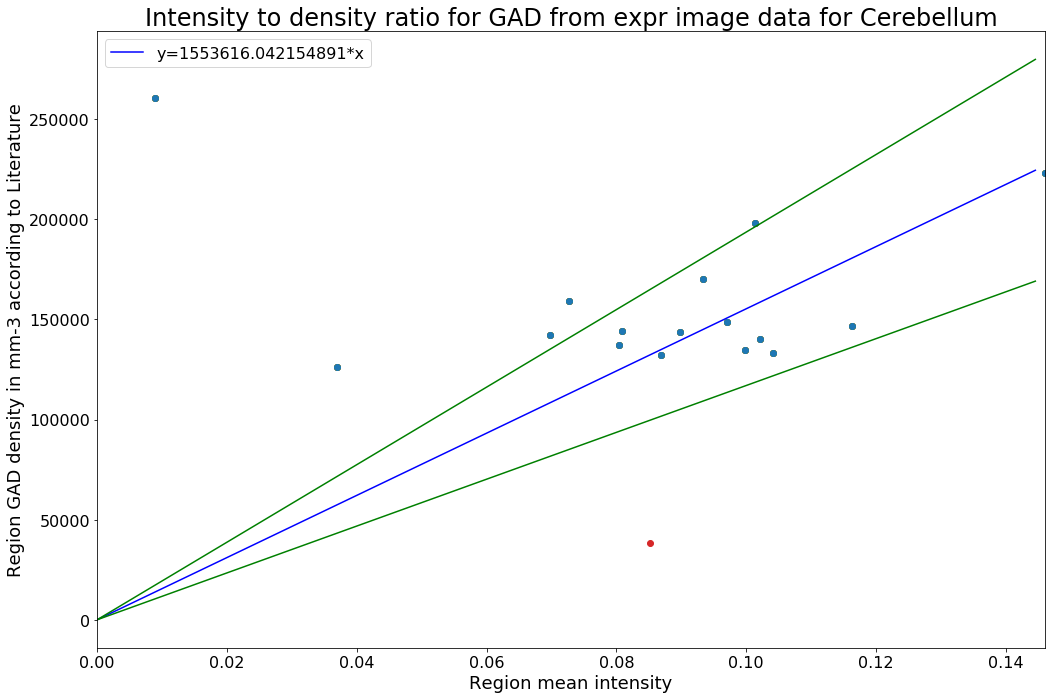

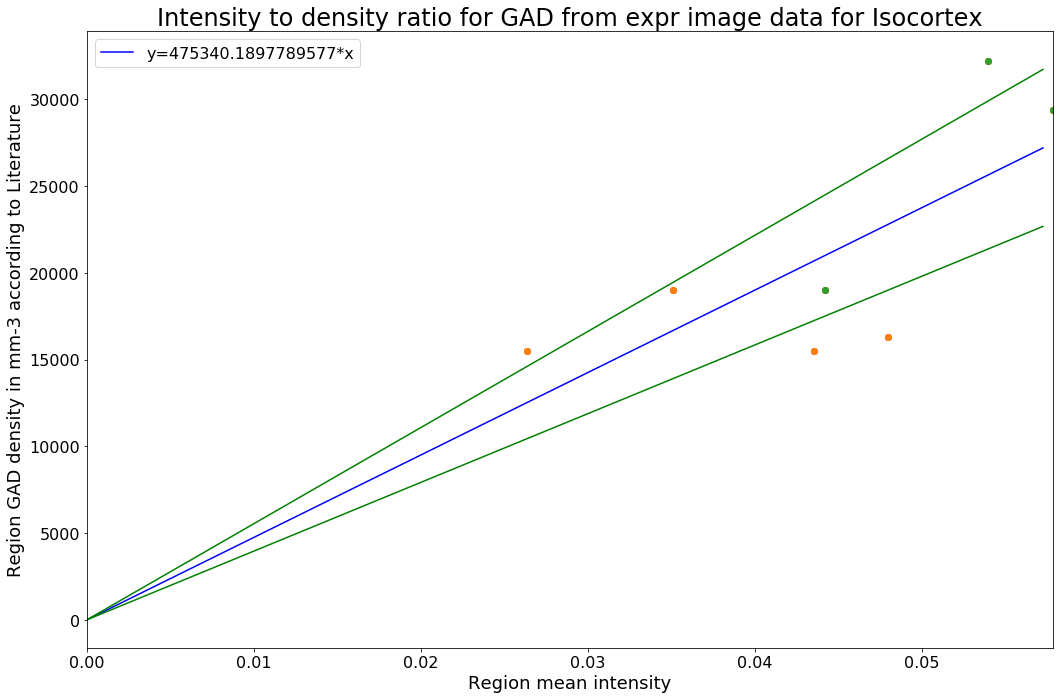

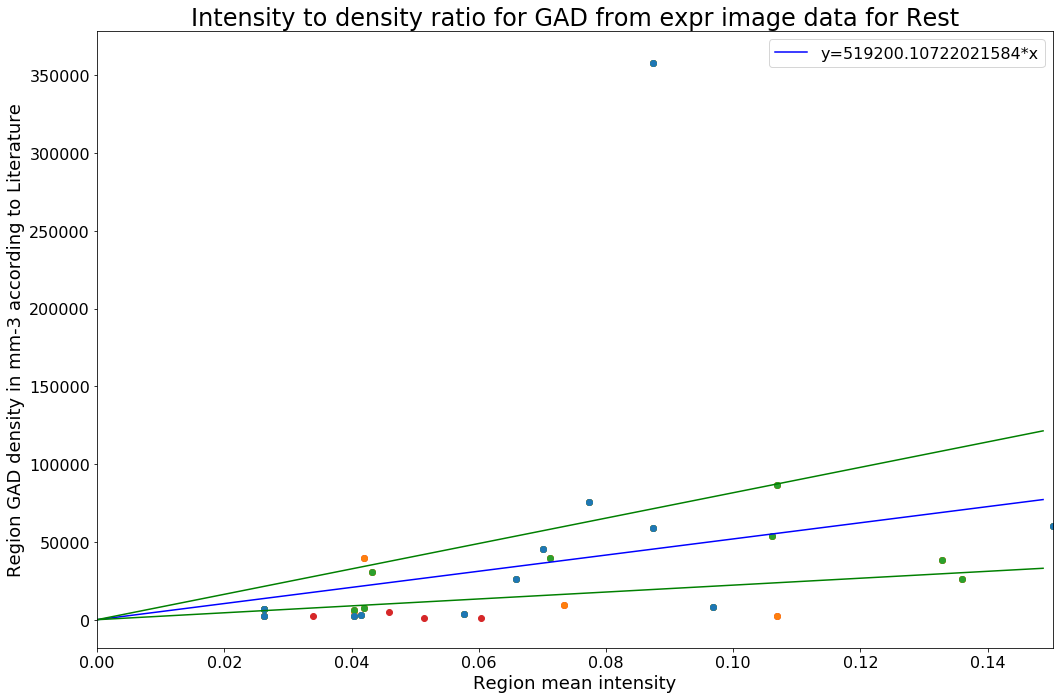

In [11]:
optimize_func = lambda x, alpha: alpha*x
marker = "GAD"
alphas = {}
stds = {}
for ireg, region in enumerate(['Cerebellum', 'Isocortex', 'Rest']):
    density = np.array(densities[ireg])
    dens_std = np.array(dens_stds[ireg])
    expression = np.array(expressions[ireg])
    name = np.array(names_corrected[ireg])

    filter_ = (~np.isnan(expression))*(density>0)
    if np.any(filter_):
        figure(figsize=(15,10))
        expression = expression[filter_]
        density = density[filter_]
        name = name[filter_]
        dens_std = dens_std[filter_]

        max_ = np.max(expression)
        for i, percent in zip([3,1,2,0],[1.0, 0.2,0.1, 0.05]):
            filter_ = (dens_std/density<percent)
            scatter(expression[filter_], density[filter_], c=rcParams['axes.prop_cycle'].by_key()['color'][i])
        x = linspace(0, max_, 100, endpoint=False, dtype=float)

        solution, pcov = curve_fit(optimize_func, 
                    xdata=expression, 
                    ydata=density)
        # Display bined standard deviation and name of the points outside it
#         low_std = []
#         high_std = []
#         for i in range(len(x)//2-1):
#             filter_ = (expression >= x[i*2])*(expression<x[(i+1)*2])
#             if np.any(filter_):
#                 error = np.sqrt(np.sum(np.power(density[filter_] - solution[0]*expression[filter_], 2)) / len(density[filter_]))
#                 low_std.append(max(x[i*2]*solution[0]-error, 0.))
#                 high_std.append(x[i*2]*solution[0]+error)
#             else:
#                 low_std.append(x[i*2]*solution[0])
#                 high_std.append(x[i*2]*solution[0])
#             out_std = (density[filter_]<low_std[-1])+(density[filter_]>high_std[-1])
#             for i, n in enumerate(name[filter_][out_std]):
#                 annotate(n, (expression[filter_][out_std][i], density[filter_][out_std][i]))
#         fill_between(x[:-2:2],low_std, high_std, alpha=0.5, color=rcParams['axes.prop_cycle'].by_key()['color'][0])
        plot(x, solution[0]*x, 'b', label='y='+str(solution[0])+"*x") 
        plot(x, (solution[0]-2*np.sqrt(pcov[0]))*x, 'g') 
        plot(x, (solution[0]+2*np.sqrt(pcov[0]))*x, 'g') 
        alphas[region] = solution[0]
        stds[region] = np.sqrt(pcov[0])[0]
        xlim([0, max_])
        ylabel("Region "+marker+" density in mm-3 according to Literature")
        xlabel("Region mean intensity")
        title("Intensity to density ratio for "+marker+" from expr image data for "+region)
        legend()
        tight_layout()
        savefig(join(OUTPUT_FOLDER, 'expr', region+"_"+marker+"_ratio_expr.png"), dpi=400)

In [14]:
print("Alphas: " + str(alphas))
print("Standard deviation: " + str(stds))
for name in marker_names:
    with open(join(OUTPUT_FOLDER, "fitting_" + name + ".json"), 'w') as fp:
        json.dump({"alphas": alphas, "std": stds}, fp, indent=4)

Alphas: {'Cerebellum': 1553616.042154891, 'Isocortex': 475340.1897789577, 'Rest': 519200.10722021584}
Standard deviation: {'Cerebellum': 191621.39513581822, 'Isocortex': 39530.68825160679, 'Rest': 148497.27905230212}
